In [1]:
# Penting tapi opsional
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
memory = 1024

if gpus:
    try:
        # Batasi penggunaan memori GPU menjadi 4024 MB (4.024 GB)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit= memory)]
        )
        print(f"GPU memory dibatasi hingga {memory} MB")
    except RuntimeError as e:
        print(e)
        
print(tf.__version__)

GPU memory dibatasi hingga 1024 MB
2.10.0


In [3]:
# pinn_teapot.py

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Set seed biar hasilnya reproducible
tf.random.set_seed(42)
np.random.seed(42)


In [ ]:
class pinn_teapot(tf.keras.Model):
    def __init__(self, layers, T_ambient, activation='relu'):
        super().__init__()
        self.T_ambient = T_ambient

        # Simpan fungsi aktivasi sebagai variabel class
        self.activation_fn = tf.keras.activations.get(activation)

        # Bangun model dengan aktivasi yang disimpan
        self.model = self.build_model(layers)

    def build_model(self, layers):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,)))
        for width in layers:
            model.add(tf.keras.layers.Dense(width, activation=self.activation_fn))
        model.add(tf.keras.layers.Dense(1, activation=None))
        return model

    def call(self, t):
        return self.model(t)

    def physics_loss(self, t):
        with tf.GradientTape() as tape:
            tape.watch(t)
            T_pred = self.call(t)
        dT_dt = tape.gradient(T_pred, t)
        residual = dT_dt * (T_pred - self.T_ambient)
        return tf.reduce_mean(tf.square(residual))

    def train_step(self, t_data, T_data, optimizer):
        with tf.GradientTape() as tape:
            T_pred = self.call(t_data)
            data_loss = tf.reduce_mean(tf.square(T_pred - T_data))
            physics_loss = self.physics_loss(t_data)
            total_loss = data_loss + physics_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return total_loss, data_loss, physics_loss


In [21]:
# Hyperparameter Early Stopping
patience = 500
best_loss = np.inf
wait = 0

# Training loop dengan EarlyStopping
for epoch in range(1, epochs+1):
    total_loss, data_loss, physics_loss = model.train_step(t_tensor, T_tensor, optimizer)
    
    # Early stopping logic
    if total_loss.numpy() < best_loss - 1e-5:  # perbaikan signifikan
        best_loss = total_loss.numpy()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}, total_loss = {total_loss.numpy():.5f}")
            break
    
    # Logging setiap 500 epoch
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss = {total_loss.numpy():.5f}")
    
    history.append(total_loss.numpy())


Epoch 500: Total Loss = 0.00513
Early stopping at epoch 850, total_loss = 0.00503


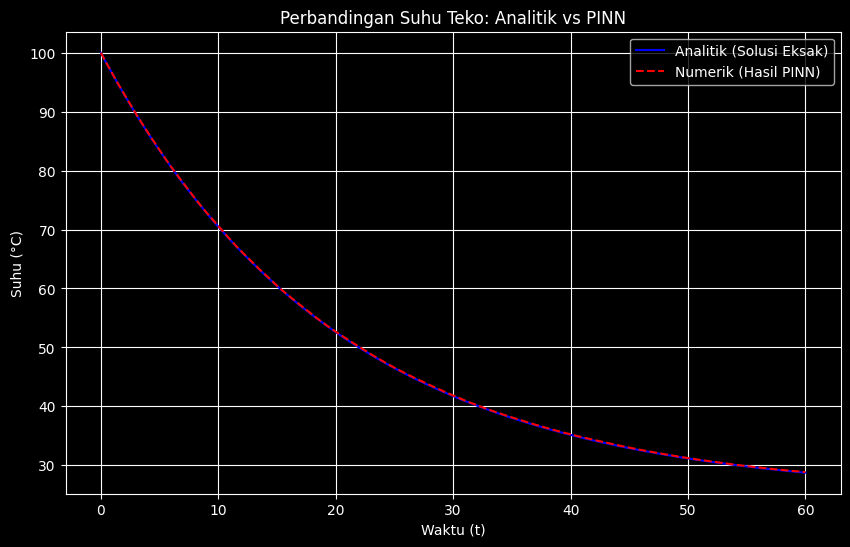

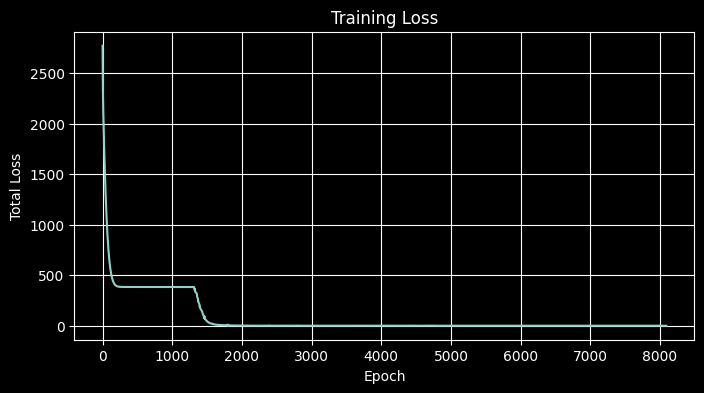

In [22]:
# ======== Visualisasi ======== #
# Generate hasil prediksi PINN
t_test = np.linspace(0, 60, 200).reshape(-1, 1)
t_test_tensor = tf.convert_to_tensor(t_test, dtype=tf.float32)
T_pinn = model.call(t_test_tensor).numpy()

# Solusi analitik
T_analytic = T_ambient + (T_initial - T_ambient) * np.exp(-k * t_test)

# Plot
plt.figure(figsize=(10,6))
plt.plot(t_test, T_analytic, label='Analitik (Solusi Eksak)', color='blue')
plt.plot(t_test, T_pinn, label='Numerik (Hasil PINN)', color='red', linestyle='--')
plt.xlabel('Waktu (t)')
plt.ylabel('Suhu (°C)')
plt.legend()
plt.title('Perbandingan Suhu Teko: Analitik vs PINN')
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8,4))
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()
